# Sanity check

Inspect analysis on two identical datasets to check features importance is alwasy the same

In [1]:
import pandas as pd

import logging
import os
import gcsfs
import sys

import time

sys.path.append('{}/decisioning-analysis/test_and_learn/production_modules/'.format(os.environ['HOME']))

from io_utils.input_extraction import pull_table
from io_utils.input_extraction import export_query_to_gcs

from preprocessing_utils.campaign_info_preprocessing import get_campaigns_relevant_info
from preprocessing_utils.campaign_info_preprocessing import create_right_granularity_level
from preprocessing_utils.input_features_preprocessing import preprocess_data
from io_utils.input_extraction import create_campaign_analysis_table

from ccp_analysis.ccp_tree_analysis import TreeRulesExtractor

from analysis_execution.run_ccp_analysis import create_logger
from analysis_execution.run_ccp_analysis import pipeline_orchestration

In [2]:
CAMPAIGN_DATA_PATHS = {'project_id':'skyuk-uk-decis-models-01-dev',
                       'dataset_id':'test_and_learn',
                       'table_id':'optimus_base_clean'}
PROP_MART_DATA_PATHS = {'project_id':'skyuk-uk-decis-models-01-dev',
                       'dataset_id':'uk_inp_prodrecs_ic',
                       'table_id':'Propensity_Model_Mart_Training'} 

OPTIMUS_COLS = {'program_label':'L1_programme',
                'campaign_label':'L2_Campaign',
                'journey_label':'L3_Journey',
                'step_label':'L4_Step',
                'variant_label':'L5_variant',
                'product_label':'product',
                'account_number_label':'account_number',
                'sale_vol_label':'sale_vol',
                'sale_aux_vol_label':'sale_auxillary_vol',
                'cell_label':'cell_type',
                'control_label':'control_type2',
                'start_date_label':'CAMPAIGN_REPORTING_START_DATE',
                'channel_label':'CHANNEL'}

PROPMART_FEAT = ['Base_Dt',
                 'account_number',
                 
                 'TAs_in_last_14d',
                 'BB_Curr_Contract_Intended_End_Dt',
                 'DTV_Curr_Contract_Intnd_End_Dt',
                 'Curr_Offer_Intended_end_Dt_DTV',
                 'Curr_Offer_Intended_end_Dt_BB',
                 'BB_Last_Activation_Dt',
                 'DTV_Last_Activation_Dt',
                 
                 'DTV_Active',
                 'BB_Active',
                 'Sports_Active',
                 'Movies_Active',
                 'MS_Active',
                 'SGE_Active',
                 'HD_Active',
                 'Sky_Box_Sets_Active',
                 'UOD_Active',
                 'SkyKids_Active',
                 'Handset_Active',
                 'skyfibre_enabled',
                 
                 'Age',
                 'h_equivalised_income_value',
                 'h_residence_type',
                 'h_number_of_adults',
                 'h_number_of_children_in_hh',
                 'h_presence_of_child_aged_0_4',
                 'h_presence_of_child_aged_5_11',
                 'h_presence_of_child_aged_12_17',
                 
                 'Broadband_Average_Demand',
                 'BT_Consumer_Market_Share',
                 'Sky_Consumer_Market_Share',
                 'Virgin_Consumer_Market_Share',
                 'TalkTalk_Consumer_Market_Share',
                 
                 
                 'Cricket_Sports_Pref',
                 'Football_Sports_Pref',
                 'Rugby_Union_Sports_Pref',
                 'Rugby_League_Sports_Pref',
                 'F1_Sports_Pref',
                 'Darts_Sports_Pref',
                 'Tennis_Sports_Pref',
                 'Racing_Sports_Pref',
                 'Boxing_Sports_Pref',
                 'Golf_Sports_Pref',
                 'NFL_Sports_Pref',
                 'Wrestling_Sports_Pref',
                 'ESports_Sports_Pref',
                 'GAA_Sports_Pref',
                 'Motorsport_Sports_Pref',
                 'Cycling_Sports_Pref',
                 'Netball_Sports_Pref',

                 'Up_Handset',
                 'Up_Mobile ']

BUCKET_ID = 'fci02/test_and_learn'

mapping_dict = {'h_presence_of_child_aged_0_4':{'No':0,'Yes':1},
                'h_presence_of_child_aged_5_11':{'No':0,'Yes':1},
                'h_presence_of_child_aged_12_17':{'No':0,'Yes':1},}

tree_pms = {'n_estimators':[5],
            'min_samples_leaf':[500],
            'max_depth':[ 5],
            'max_allowed_depth':5,
            'min_allowed_node_size':5000,
            'n_best_features':3,
            'njobs':14}

control_name_dict = {'skyOptimusGetMore':'Campaign control','skyOptimusDMO':'Fallow Group'}

PROJECT_ID_1 = 'skyuk-uk-decis-models-01-dev'
DATASET_ID_1 = 'test_and_learn'
BUCKET_ID = 'fci02/test_and_learn'
CAMPAING_TABLE_NAME = 'optimus_base_clean'

In [3]:
campaigns_list = get_campaigns_relevant_info(PROJECT_ID_1,DATASET_ID_1,CAMPAING_TABLE_NAME,
                                             OPTIMUS_COLS['program_label'],
                                             OPTIMUS_COLS['campaign_label'],
                                             OPTIMUS_COLS['start_date_label'], 
                                             OPTIMUS_COLS['product_label'],
                                             OPTIMUS_COLS['journey_label'],
                                             OPTIMUS_COLS['step_label'],
                                             OPTIMUS_COLS['variant_label']
                                            )
campaigns_list.head(10)

,campaign_program,campaign_name,start_date,journey,step,variant,product,channel
0,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_JANUARY_EM1_3127-4_(DM241975)_...,TV Winback,EM&DM
1,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_JANUARY_EM8_3127-8_(DM243684)_...,TV Winback,EM&DM
2,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_JANUARY_EM8_3127-8_(DM243684)_...,TV Winback,EM&DM
3,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_JANUARY_EM8_3127-8_(DM243684)_...,TV Winback,EM&DM
4,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_JANUARY_EM8_3127-8_(DM243684)_...,TV Winback,EM&DM
5,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_JANUARY_EM8_3127-8_(DM243684)_...,TV Winback,EM&DM
6,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_JANUARY_EM8_3127-8_(DM243684)_...,TV Winback,EM&DM
7,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_DECEMBER_EM8-2737-18_(DM231961...,TV Winback,EM&DM
8,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_DECEMBER_EM8-2737-18_(DM231961...,TV Winback,EM&DM
9,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM EM OptIn UK 2018,CAM0002279_EM_Ents_Reactive_DMEMOptin_Marketin...,OPTIMUS_WINBACK_DECEMBER_EM8-2737-18_(DM231961...,TV Winback,EM&DM


In [11]:
pd.unique(campaigns_list['campaign_name'])

array(['Winback DTV UK', 'Winback', 'Pending Cancel',
       'Pending Cancel DTV UK', 'Active Block UK', 'Pending Cancel BB UK',
       'Mobile', 'Pending Cancel DTV ROI', 'Cinema Christmas',
       'Winback DTV ROI', 'Pending Cancel TV UK', 'Product Downgrades',
       'Mobile Christmas', 'Active Block', 'Upgrade BB UK',
       'Pending Cancel BB ROI', 'Cinema Range', 'Sports Pay Day',
       'ALC UK', 'Mobile Recontract', 'Cinema (Oscars and Halfterm)',
       'Mobile Samsung Launch', 'Sky Go Valentines',
       'Mobile Iphone BEP UK', 'Sports Derby Day',
       'Winback DTV UK TOP TIER TEST', 'Sports F1', 'Kids 1MF',
       'Mobile Huawei', 'Mobile Iphone Monster Savings',
       'Mobile Huawei Launch', 'Cinema Easter', 'Sports Golf',
       'Mobile Activation Trigger', 'Kids Half Term 1MF', 'QE Q2 Test',
       'Sports F1 Phase 2', 'Winback DTV UK TOP TIER TEST-ENDED',
       'Winback DTV UK 2019', 'QE Q2 Loyalty', 'Mobile Half Price Data',
       'Sports Cricket', 'Winback DTV UK 

In [5]:
campaigns_list[campaigns_list['campaign_name'].isin(['Winback DTV UK', 'Winback', 'Pending Cancel','Sports The Open','Mobile Huawei Launch',
                                                     'Cinema (Oscars and Halfterm)','Kids Half Term 1MF','Summer Cinema','Mobile Samsung Launch','Pending Cancel DTV UK'])].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            21964, 21965, 21966, 21967, 21968, 21969, 21970, 21971, 21972,
            21973],
           dtype='int64', length=10934)

In [6]:
import numpy as np
drop_perf=campaigns_list[campaigns_list['campaign_name'].isin(['Winback DTV UK', 'Winback', 'Pending Cancel','Sports The Open','Mobile Huawei Launch',
                                                     'Cinema (Oscars and Halfterm)','Kids Half Term 1MF','Summer Cinema','Mobile Samsung Launch','Pending Cancel DTV UK'])].index
perf_subset = campaigns_list.drop(drop_perf)
perf_subset.to_csv('gs://'+BUCKET_ID+'/bckup_analyzed_campaigns_perf_run.csv',index=False)

In [10]:
pipeline_orchestration(CAMPAIGN_DATA_PATHS,
                       PROP_MART_DATA_PATHS,
                       BUCKET_ID,
                       'bckup_analyzed_campaigns_perf_run.csv',
                       OPTIMUS_COLS,
                       PROPMART_FEAT,
                       'Base_Dt',
                       control_name_dict,
                       'Treatment',
                       mapping_dict,
                       tree_pms,
                       'campaign_forest_test_2',
                       rstate=42,
                       tuning=False,
                       show=False,
                       log_file=None,
                       check_point_value=2,granularity_levels=['overall','channel'])

08-Nov-19 15:22:41 - ##################### Customer Cohort Performance analysis #####################
08-Nov-19 15:22:41 - 
####### Running analysi with the following setup #######

                    #### campaign_data_paths ####
{'dataset_id': 'test_and_learn', 'project_id': 'skyuk-uk-decis-models-01-dev', 'table_id': 'optimus_base_clean'}

                    #### prop_mart_data_paths ####
{'dataset_id': 'uk_inp_prodrecs_ic', 'project_id': 'skyuk-uk-decis-models-01-dev', 'table_id': 'Propensity_Model_Mart_Training'}

                    #### bucket_id ####
fci02/test_and_learn

                    #### campaigns_bkup_table_name ####
bckup_analyzed_campaigns_perf_run.csv

                    #### optimus_columns ####
{'campaign_label': 'L2_Campaign', 'product_label': 'product', 'journey_label': 'L3_Journey', 'variant_label': 'L5_variant', 'cell_label': 'cell_type', 'channel_label': 'CHANNEL', 'control_label': 'control_type2', 'start_date_label': 'CAMPAIGN_REPORTING_START_DATE', 'ste

Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_ctr_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_ctr_tmp to gs://fci02/test_and_learn/Campaign_ctr_tmp.csv


08-Nov-19 15:23:02 - Building treatment table


Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


08-Nov-19 15:23:45 - Control: 22870 sample points --- Treatment: 416674 sample points
08-Nov-19 15:23:45 - Control: 2.335% class imbalance --- Treatment: 3.419% class imbalance
08-Nov-19 15:23:45 - Data preprocessing
08-Nov-19 15:23:45 - #################### DATA PREPROCESSING ####################
08-Nov-19 15:23:45 - 1) Removing features with high percentage of nulls
08-Nov-19 15:23:45 - 1a) Setting boolean input features to integers
08-Nov-19 15:23:45 - 1b) Removing constant features
08-Nov-19 15:23:45 - Removing ['UOD_Active', 'Sky_Consumer_Market_Share', 'Virgin_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'Wrestling_Sports_Pref', 'ESports_Sports_Pref', 'Netball_Sports_Pref', 'ncomms']
08-Nov-19 15:23:45 - 2) Features engineering
08-Nov-19 15:23:45 - 2a) Mappings
08-Nov-19 15:23:45 - 2b) Rounding income value
08-Nov-19 15:23:45 - 2c) Creating contract/offer status features
08-Nov-19 15:23:46 - 2d) Creating number of days of tenure
08-Nov-19 15:23:46 -      Number of ro

Pipe: 42
42


08-Nov-19 15:24:12 - Minimal Random Forest training
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    0.2s finished
08-Nov-19 15:24:12 - Collecting analysis of performances
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
08-Nov-19 15:24:13 - Best top 3 features extraction. Single tree performance analysis
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  

['DTV_offer_status_out_of_offer', 'BB_offer_status_out_of_offer', 'BB_Active']
Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_ctr_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_ctr_tmp to gs://fci02/test_and_learn/Campaign_ctr_tmp.csv


08-Nov-19 15:24:32 - Building treatment table


Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


08-Nov-19 15:25:11 - Control: 7592 sample points --- Treatment: 156547 sample points
08-Nov-19 15:25:11 - Control: 1.436% class imbalance --- Treatment: 2.333% class imbalance
08-Nov-19 15:25:11 - Data preprocessing
08-Nov-19 15:25:11 - #################### DATA PREPROCESSING ####################
08-Nov-19 15:25:11 - 1) Removing features with high percentage of nulls
08-Nov-19 15:25:11 - 1a) Setting boolean input features to integers
08-Nov-19 15:25:11 - 1b) Removing constant features
08-Nov-19 15:25:11 - Removing ['UOD_Active', 'Sky_Consumer_Market_Share', 'Virgin_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'Racing_Sports_Pref', 'Golf_Sports_Pref', 'Wrestling_Sports_Pref', 'ESports_Sports_Pref', 'GAA_Sports_Pref', 'Motorsport_Sports_Pref', 'Cycling_Sports_Pref', 'Netball_Sports_Pref', 'ncomms']
08-Nov-19 15:25:11 - 2) Features engineering
08-Nov-19 15:25:11 - 2a) Mappings
08-Nov-19 15:25:11 - 2b) Rounding income value
08-Nov-19 15:25:11 - 2c) Creating contract/offer stat

Pipe: 42


08-Nov-19 15:25:21 - Minimal Random Forest training


42


[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    0.1s finished
08-Nov-19 15:25:21 - Collecting analysis of performances
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
08-Nov-19 15:25:22 - Best top 3 features extraction. Single tree performance analysis
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s


['DTV_offer_status_out_of_offer', 'BB_Active', 'Age']
Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_ctr_tmp


08-Nov-19 15:25:36 - Building treatment table


Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_ctr_tmp to gs://fci02/test_and_learn/Campaign_ctr_tmp.csv
Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


08-Nov-19 15:25:55 - Control: 2641 sample points --- Treatment: 48217 sample points
08-Nov-19 15:25:55 - Control: 1.212% class imbalance --- Treatment: 2.57% class imbalance
08-Nov-19 15:25:55 - Data preprocessing
08-Nov-19 15:25:55 - #################### DATA PREPROCESSING ####################
08-Nov-19 15:25:55 - 1) Removing features with high percentage of nulls
08-Nov-19 15:25:55 - 1a) Setting boolean input features to integers
08-Nov-19 15:25:55 - 1b) Removing constant features
08-Nov-19 15:25:55 - Removing ['UOD_Active', 'Sky_Consumer_Market_Share', 'Virgin_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'F1_Sports_Pref', 'Darts_Sports_Pref', 'Tennis_Sports_Pref', 'Racing_Sports_Pref', 'Boxing_Sports_Pref', 'Golf_Sports_Pref', 'NFL_Sports_Pref', 'Wrestling_Sports_Pref', 'ESports_Sports_Pref', 'GAA_Sports_Pref', 'Motorsport_Sports_Pref', 'Cycling_Sports_Pref', 'Netball_Sports_Pref', 'ncomms']
08-Nov-19 15:25:55 - 2) Features engineering
08-Nov-19 15:25:55 - 2a) Mappings


Pipe: 42
42


08-Nov-19 15:25:58 - Collecting analysis of performances
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
08-Nov-19 15:25:58 - Best top 3 features extraction. Single tree performance analysis
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    0.0s finished
08-Nov-19 15:26:00 - Formatting rules table
08-Nov-19 15:26:00 - Relevant target(s) for this campaign: ['TV_REINSTATE']
08-Nov-19 15:26:00 - Selecting journey(s) [

['Age', 'DTV_offer_status_out_of_offer', 'DTV_Active']
Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_ctr_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_ctr_tmp to gs://fci02/test_and_learn/Campaign_ctr_tmp.csv


08-Nov-19 15:26:15 - Building treatment table


Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


08-Nov-19 15:26:54 - Control: 15612 sample points --- Treatment: 280185 sample points
08-Nov-19 15:26:54 - Control: 2.549% class imbalance --- Treatment: 3.415% class imbalance
08-Nov-19 15:26:54 - Data preprocessing
08-Nov-19 15:26:54 - #################### DATA PREPROCESSING ####################
08-Nov-19 15:26:54 - 1) Removing features with high percentage of nulls
08-Nov-19 15:26:54 - 1a) Setting boolean input features to integers
08-Nov-19 15:26:54 - 1b) Removing constant features
08-Nov-19 15:26:54 - Removing ['UOD_Active', 'Sky_Consumer_Market_Share', 'Virgin_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'Wrestling_Sports_Pref', 'ESports_Sports_Pref', 'Netball_Sports_Pref', 'ncomms']
08-Nov-19 15:26:54 - 2) Features engineering
08-Nov-19 15:26:54 - 2a) Mappings
08-Nov-19 15:26:54 - 2b) Rounding income value
08-Nov-19 15:26:54 - 2c) Creating contract/offer status features
08-Nov-19 15:26:55 - 2d) Creating number of days of tenure
08-Nov-19 15:26:55 -      Number of ro

Pipe: 42
42


08-Nov-19 15:27:12 - Minimal Random Forest training
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    0.1s finished
08-Nov-19 15:27:12 - Collecting analysis of performances
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
08-Nov-19 15:27:12 - Best top 3 features extraction. Single tree performance analysis
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  

['DTV_offer_status_out_of_offer', 'DTV_offer_status_soon_out_of_offer', 'DTV_contract_status_out_of_contract']
Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_ctr_tmp


08-Nov-19 15:27:31 - Building treatment table


Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_ctr_tmp to gs://fci02/test_and_learn/Campaign_ctr_tmp.csv
Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


08-Nov-19 15:27:52 - Control: 0 sample points --- Treatment: 16 sample points
08-Nov-19 15:27:52 - Control: nan% class imbalance --- Treatment: 0.0% class imbalance
08-Nov-19 15:27:52 - Missing control group for this campaign. Analysis will focus just on conversion rate
08-Nov-19 15:27:52 - Data preprocessing
08-Nov-19 15:27:52 - #################### DATA PREPROCESSING ####################
08-Nov-19 15:27:52 - 1) Removing features with high percentage of nulls
08-Nov-19 15:27:52 - 1a) Setting boolean input features to integers
08-Nov-19 15:27:52 - 1b) Removing constant features
08-Nov-19 15:27:52 - Removing ['TAs_in_last_14d', 'UOD_Active', 'SkyKids_Active', 'Handset_Active', 'skyfibre_enabled', 'Sky_Consumer_Market_Share', 'Virgin_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'Cricket_Sports_Pref', 'Football_Sports_Pref', 'Rugby_Union_Sports_Pref', 'Rugby_League_Sports_Pref', 'F1_Sports_Pref', 'Darts_Sports_Pref', 'Tennis_Sports_Pref', 'Racing_Sports_Pref', 'Boxing_Sports_

Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_ctr_tmp


08-Nov-19 15:28:12 - Building treatment table


Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_ctr_tmp to gs://fci02/test_and_learn/Campaign_ctr_tmp.csv
Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


08-Nov-19 15:30:54 - Control: 315 sample points --- Treatment: 2552877 sample points
08-Nov-19 15:30:54 - Control: 0.0% class imbalance --- Treatment: 0.176% class imbalance
08-Nov-19 15:30:54 - Data preprocessing
08-Nov-19 15:30:54 - #################### DATA PREPROCESSING ####################
08-Nov-19 15:30:54 - 1) Removing features with high percentage of nulls
08-Nov-19 15:30:54 - 1a) Setting boolean input features to integers
08-Nov-19 15:30:54 - 1b) Removing constant features
08-Nov-19 15:30:54 - Removing ['TAs_in_last_14d', 'DTV_Active', 'UOD_Active', 'Handset_Active', 'Sky_Consumer_Market_Share', 'Virgin_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'Cricket_Sports_Pref', 'Rugby_Union_Sports_Pref', 'Rugby_League_Sports_Pref', 'F1_Sports_Pref', 'Darts_Sports_Pref', 'Tennis_Sports_Pref', 'Racing_Sports_Pref', 'Boxing_Sports_Pref', 'Golf_Sports_Pref', 'NFL_Sports_Pref', 'Wrestling_Sports_Pref', 'ESports_Sports_Pref', 'GAA_Sports_Pref', 'Motorsport_Sports_Pref', 'Cycli

Pipe: 42
42


08-Nov-19 15:33:43 - Minimal Random Forest training
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    4.5s finished
08-Nov-19 15:33:48 - Collecting analysis of performances
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished
08-Nov-19 15:33:49 - Best top 3 features extraction. Single tree performance analysis
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  

['SGE_Active', 'Age', 'h_presence_of_child_aged_5_11']
Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_ctr_tmp


08-Nov-19 15:35:14 - Building treatment table


Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_ctr_tmp to gs://fci02/test_and_learn/Campaign_ctr_tmp.csv
Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


08-Nov-19 15:36:30 - Control: 0 sample points --- Treatment: 1147530 sample points
08-Nov-19 15:36:30 - Control: nan% class imbalance --- Treatment: 0.136% class imbalance
08-Nov-19 15:36:30 - Missing control group for this campaign. Analysis will focus just on conversion rate
08-Nov-19 15:36:30 - Data preprocessing
08-Nov-19 15:36:30 - #################### DATA PREPROCESSING ####################
08-Nov-19 15:36:30 - 1) Removing features with high percentage of nulls
08-Nov-19 15:36:31 - 1a) Setting boolean input features to integers
08-Nov-19 15:36:31 - 1b) Removing constant features
08-Nov-19 15:36:36 - Removing ['UOD_Active', 'Sky_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'ncomms']
08-Nov-19 15:36:36 - 2) Features engineering
08-Nov-19 15:36:36 - 2a) Mappings
08-Nov-19 15:36:37 - 2b) Rounding income value
08-Nov-19 15:36:38 - 2c) Creating contract/offer status features
08-Nov-19 15:37:17 - 2d) Creating number of days of tenure
08-Nov-19 15:37:44 -      Number of rows

Pipe: 42
42


08-Nov-19 15:38:59 - Minimal Random Forest training
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    1.0s finished
08-Nov-19 15:39:01 - Collecting analysis of performances
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
08-Nov-19 15:39:01 - Best top 3 features extraction. Single tree performance analysis
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  

['h_number_of_children_in_hh', 'Movies_Active', 'tenure_months']
Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_ctr_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_ctr_tmp to gs://fci02/test_and_learn/Campaign_ctr_tmp.csv


08-Nov-19 15:40:03 - Building treatment table


Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
08-Nov-19 15:40:43 - Control: 315 sample points --- Treatment: 230641 sample points
08-Nov-19 15:40:43 - Control: 0.0% class imbalance --- Treatment: 0.162% class imbalance
08-Nov-19 15:40:43 - Data preprocessing
08-Nov-19 15:40:43 - #################### DATA PREPROCESSING ####################
08-Nov-19 15:40:43 - 1) Removing features with high percentage of nulls
08-Nov-19 15:40:43 - 1a) Setting boolean input features to integers
08-Nov-19 15:40:43 - 1b) Removing constant features
08-Nov-19 15:40:43 - Removing ['TAs_in_last_14d', 'DTV_Active', 'UOD_Active', 'Handset_Active', 'Sky_Consumer_Market_Share', 'Virgin_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'Cricket_Sports_Pref', 'Rugby_Union_Sports_Pref', 'Rugby_League_Sports_Pref', 'F1_Sports_Pre

Pipe: 42


08-Nov-19 15:40:58 - Minimal Random Forest training


42


[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    0.1s finished
08-Nov-19 15:40:58 - Collecting analysis of performances
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
08-Nov-19 15:40:59 - Best top 3 features extraction. Single tree performance analysis
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s


['Age', 'h_equivalised_income_value', 'SGE_Active']
Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_ctr_tmp


08-Nov-19 15:41:16 - Building treatment table


Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_ctr_tmp to gs://fci02/test_and_learn/Campaign_ctr_tmp.csv
Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


08-Nov-19 15:42:37 - Control: 0 sample points --- Treatment: 1193005 sample points
08-Nov-19 15:42:37 - Control: nan% class imbalance --- Treatment: 0.216% class imbalance
08-Nov-19 15:42:37 - Missing control group for this campaign. Analysis will focus just on conversion rate
08-Nov-19 15:42:37 - Data preprocessing
08-Nov-19 15:42:37 - #################### DATA PREPROCESSING ####################
08-Nov-19 15:42:37 - 1) Removing features with high percentage of nulls
08-Nov-19 15:42:38 - 1a) Setting boolean input features to integers
08-Nov-19 15:42:38 - 1b) Removing constant features
08-Nov-19 15:42:43 - Removing ['UOD_Active', 'Sky_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'ncomms']
08-Nov-19 15:42:43 - 2) Features engineering
08-Nov-19 15:42:43 - 2a) Mappings
08-Nov-19 15:42:44 - 2b) Rounding income value
08-Nov-19 15:42:45 - 2c) Creating contract/offer status features
08-Nov-19 15:43:26 - 2d) Creating number of days of tenure
08-Nov-19 15:43:53 -      Number of rows

Pipe: 42
42


08-Nov-19 15:45:12 - Minimal Random Forest training
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    1.1s finished
08-Nov-19 15:45:13 - Collecting analysis of performances
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
08-Nov-19 15:45:14 - Best top 3 features extraction. Single tree performance analysis
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  

['Age', 'SGE_Active', 'tenure_months']


08-Nov-19 15:46:04 - Performance information saved in gs://fci02/test_and_learn/campaign_analysis_perf_2019-11-8_check_point_2.csv
08-Nov-19 15:46:04 - Collecting results, saving to GCP
08-Nov-19 15:46:04 - Saving table to GCP


<class 'str'>
0         skyOptimusDMO
1         skyOptimusDMO
2         skyOptimusDMO
3         skyOptimusDMO
4         skyOptimusDMO
            ...        
18    skyOptimusGetMore
22    skyOptimusGetMore
2     skyOptimusGetMore
25    skyOptimusGetMore
16    skyOptimusGetMore
Name: L1_programme, Length: 134, dtype: object
STRING
<class 'str'>
0     Winback DTV UK
1     Winback DTV UK
2     Winback DTV UK
3     Winback DTV UK
4     Winback DTV UK
           ...      
18            Mobile
22            Mobile
2             Mobile
25            Mobile
16            Mobile
Name: L2_Campaign, Length: 134, dtype: object
STRING
<class 'datetime.date'>
0     2018-10-15
1     2018-10-15
2     2018-10-15
3     2018-10-15
4     2018-10-15
         ...    
18    2018-11-30
22    2018-11-30
2     2018-11-30
25    2018-11-30
16    2018-11-30
Name: CAMPAIGN_REPORTING_START_DATE, Length: 134, dtype: object
DATE
<class 'str'>
0     TV Winback       
1     TV Winback       
2     TV Winback       
3   

08-Nov-19 15:46:14 - Updating the list of analyzed campaigns
08-Nov-19 15:46:16 - Analyzing campaign

campaign_program    skyOptimusGetMore
campaign_name        Cinema Christmas
start_date                 2018-12-07
product             Cinema           
Name: 17408, dtype: object


08-Nov-19 15:46:16 - ##################### Performing analysis at overall level #####################
08-Nov-19 15:46:16 - Using prop-mart snapshot at 2018-11-30
08-Nov-19 15:46:16 - Relevant target(s) for this campaign: ['sale_target']
08-Nov-19 15:46:16 - Selecting journey(s) ['CAM0002297 Get More Cinema Xmas EM DM UK 2018', 'CAM0002297 Get More Cinema Xmas DM UK ROI 2018', 'CAM0002297 Get More Cinema Xmas DM UK 2018', 'CAM0002297 Get More Cinema Xmas EM UK ROI 2018']
08-Nov-19 15:46:16 - Building control table


Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_ctr_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_ctr_tmp to gs://fci02/test_and_learn/Campaign_ctr_tmp.csv


08-Nov-19 15:46:31 - Building treatment table


Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


08-Nov-19 15:48:48 - Control: 82480 sample points --- Treatment: 1040362 sample points
08-Nov-19 15:48:48 - Control: 1.474% class imbalance --- Treatment: 1.392% class imbalance
08-Nov-19 15:48:48 - Data preprocessing
08-Nov-19 15:48:48 - #################### DATA PREPROCESSING ####################
08-Nov-19 15:48:48 - 1) Removing features with high percentage of nulls
08-Nov-19 15:48:48 - 1a) Setting boolean input features to integers
08-Nov-19 15:48:48 - 1b) Removing constant features
08-Nov-19 15:48:48 - Removing ['Movies_Active', 'Sky_Consumer_Market_Share', 'Virgin_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'Cycling_Sports_Pref', 'ncomms']
08-Nov-19 15:48:48 - 2) Features engineering
08-Nov-19 15:48:48 - 2a) Mappings
08-Nov-19 15:48:48 - 2b) Rounding income value
08-Nov-19 15:48:48 - 2c) Creating contract/offer status features
08-Nov-19 15:48:51 - 2d) Creating number of days of tenure
08-Nov-19 15:48:53 -      Number of rows lost: 7676
08-Nov-19 15:48:53 -      % of

Pipe: 42
42


08-Nov-19 15:50:01 - Minimal Random Forest training
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    0.9s finished
08-Nov-19 15:50:02 - Collecting analysis of performances
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
08-Nov-19 15:50:02 - Best top 3 features extraction. Single tree performance analysis
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  

['Sky_Box_Sets_Active', 'tenure_months', 'SkyKids_Active']
Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_ctr_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_ctr_tmp to gs://fci02/test_and_learn/Campaign_ctr_tmp.csv


08-Nov-19 15:50:41 - Building treatment table


Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
08-Nov-19 15:51:18 - Control: 11342 sample points --- Treatment: 174763 sample points
08-Nov-19 15:51:18 - Control: 0.935% class imbalance --- Treatment: 1.911% class imbalance
08-Nov-19 15:51:18 - Data preprocessing
08-Nov-19 15:51:18 - #################### DATA PREPROCESSING ####################
08-Nov-19 15:51:18 - 1) Removing features with high percentage of nulls
08-Nov-19 15:51:18 - 1a) Setting boolean input features to integers
08-Nov-19 15:51:18 - 1b) Removing constant features
08-Nov-19 15:51:18 - Removing ['DTV_Active', 'Movies_Active', 'Sky_Consumer_Market_Share', 'Virgin_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'Tennis_Sports_Pref', 'Racing_Sports_Pref', 'Golf_Sports_Pref', 'NFL_Sports_Pref', 'Wrestling_Sports_Pref', 'ESports_Sport

Pipe: 42
42


08-Nov-19 15:51:29 - Minimal Random Forest training
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    0.0s finished
08-Nov-19 15:51:29 - Collecting analysis of performances
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
08-Nov-19 15:51:29 - Best top 3 features extraction. Single tree performance analysis
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  

['SGE_Active', 'tenure_months', 'Sky_Box_Sets_Active']
Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_ctr_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_ctr_tmp to gs://fci02/test_and_learn/Campaign_ctr_tmp.csv


08-Nov-19 15:51:53 - Building treatment table


Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp
Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp.csv


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
08-Nov-19 15:52:55 - Control: 71223 sample points --- Treatment: 866137 sample points
08-Nov-19 15:52:55 - Control: 1.558% class imbalance --- Treatment: 1.286% class imbalance
08-Nov-19 15:52:55 - Data preprocessing
08-Nov-19 15:52:55 - #################### DATA PREPROCESSING ####################
08-Nov-19 15:52:55 - 1) Removing features with high percentage of nulls
08-Nov-19 15:52:55 - 1a) Setting boolean input features to integers
08-Nov-19 15:52:55 - 1b) Removing constant features
08-Nov-19 15:52:56 - Removing ['Movies_Active', 'Sky_Consumer_Market_Share', 'Virgin_Consumer_Market_Share', 'TalkTalk_Consumer_Market_Share', 'Cycling_Sports_Pref', 'ncomms']
08-Nov-19 15:52:56 - 2) Features engineering
08-Nov-19 15:52:56 - 2a) Mappings
08-Nov-19 15:52:56 - 2b)

Pipe: 42
42


08-Nov-19 15:53:56 - Minimal Random Forest training
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=14)]: Done   5 out of   5 | elapsed:    0.9s finished
08-Nov-19 15:53:57 - Collecting analysis of performances
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
08-Nov-19 15:53:57 - Best top 3 features extraction. Single tree performance analysis
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  

['tenure_months', 'SkyKids_Active', 'Sky_Box_Sets_Active']


08-Nov-19 15:54:20 - Performance information saved in gs://fci02/test_and_learn/campaign_analysis_perf_2019-11-8_check_point_3.csv
08-Nov-19 15:54:20 - Collecting results, saving to GCP
08-Nov-19 15:54:20 - Saving table to GCP


<class 'str'>
0     skyOptimusGetMore
1     skyOptimusGetMore
2     skyOptimusGetMore
3     skyOptimusGetMore
4     skyOptimusGetMore
5     skyOptimusGetMore
6     skyOptimusGetMore
7     skyOptimusGetMore
8     skyOptimusGetMore
9     skyOptimusGetMore
10    skyOptimusGetMore
11    skyOptimusGetMore
12    skyOptimusGetMore
13    skyOptimusGetMore
14    skyOptimusGetMore
15    skyOptimusGetMore
16    skyOptimusGetMore
17    skyOptimusGetMore
18    skyOptimusGetMore
19    skyOptimusGetMore
20    skyOptimusGetMore
21    skyOptimusGetMore
0     skyOptimusGetMore
1     skyOptimusGetMore
2     skyOptimusGetMore
3     skyOptimusGetMore
4     skyOptimusGetMore
5     skyOptimusGetMore
6     skyOptimusGetMore
7     skyOptimusGetMore
8     skyOptimusGetMore
9     skyOptimusGetMore
10    skyOptimusGetMore
11    skyOptimusGetMore
12    skyOptimusGetMore
13    skyOptimusGetMore
0     skyOptimusGetMore
1     skyOptimusGetMore
2     skyOptimusGetMore
3     skyOptimusGetMore
4     skyOptimusGetMore
5 

08-Nov-19 15:54:29 - Updating the list of analyzed campaigns
08-Nov-19 15:54:30 - Full campaign analysis completed: elapsed time = 1909.06 seconds


In [79]:
BUCKET_ID

'fci02/test_and_learn'

In [10]:
tmp = pd.read_csv('gs://'+BUCKET_ID+'/bckup_analyzed_campaigns_test.csv')#.drop_duplicates()

In [11]:
tmp.shape

(10806, 8)

In [12]:
tmp.drop_duplicates().shape

(10806, 8)

In [14]:
pd.unique(tmp.campaign_name)

array(['Winback DTV UK', 'Winback', 'Pending Cancel',
       'Pending Cancel DTV UK'], dtype=object)

In [16]:
campaigns_list[campaigns_list.campaign_name=='Pending Cancel DTV UK'].shape

(10256, 8)

In [17]:
tmp[tmp.campaign_name=='Pending Cancel DTV UK'].shape

(10256, 8)

In [196]:
tmp.shape

(21568, 8)

In [197]:
tmp.head(10)

,campaign_program,campaign_name,start_date,journey,step,variant,product,channel
0,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_1,CAM0002279_DTV_WINBACK_DM_1_UK_CAM0002279_DM_E...,TV Winback,DM Only
1,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_1,CAM0002279_DTV_WINBACK_DM_1_UK_CAM0002279_DM_E...,TV Winback,DM Only
2,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_1,CAM0002279_DTV_WINBACK_DM_1_UK_CAM0002279_DM_E...,TV Winback,DM Only
3,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_1,CAM0002279_DTV_WINBACK_DM_1_UK_CAM0002279_DM_E...,TV Winback,DM Only
4,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_1,CAM0002279_DTV_WINBACK_DM_1_UK_CAM0002279_DM_E...,TV Winback,DM Only
5,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_3,CAM0002279_DTV_WINBACK_DM_3_UK_1819_CAM0002279...,TV Winback,DM Only
6,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_3,CAM0002279_DTV_WINBACK_DM_3_UK_1819_CAM0002279...,TV Winback,DM Only
7,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_3,CAM0002279_DTV_WINBACK_DM_3_UK_1819_CAM0002279...,TV Winback,DM Only
8,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_3,CAM0002279_DTV_WINBACK_DM_3_UK_1819_CAM0002279...,TV Winback,DM Only
9,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_3,CAM0002279_DTV_WINBACK_DM_3_UK_1819_CAM0002279...,TV Winback,DM Only


In [130]:
pd.unique(tmp.campaign_name)

array(['Winback DTV UK', 'Winback', 'Pending Cancel',
       'Pending Cancel DTV UK', 'Active Block UK', 'Pending Cancel BB UK',
       'Mobile', 'Pending Cancel DTV ROI', 'Cinema Christmas',
       'Winback DTV ROI', 'Pending Cancel TV UK', 'Product Downgrades',
       'Mobile Christmas', 'Active Block', 'Upgrade BB UK',
       'Pending Cancel BB ROI', 'Cinema Range', 'Sports Pay Day',
       'ALC UK', 'Mobile Recontract', 'Cinema (Oscars and Halfterm)',
       'Mobile Samsung Launch', 'Sky Go Valentines',
       'Mobile Iphone BEP UK', 'Sports Derby Day',
       'Winback DTV UK TOP TIER TEST', 'Sports F1', 'Kids 1MF',
       'Mobile Huawei', 'Mobile Iphone Monster Savings',
       'Mobile Huawei Launch', 'Cinema Easter', 'Sports Golf',
       'Mobile Activation Trigger', 'Kids Half Term 1MF', 'QE Q2 Test',
       'Sports F1 Phase 2', 'Winback DTV UK TOP TIER TEST-ENDED',
       'Winback DTV UK 2019', 'QE Q2 Loyalty', 'Mobile Half Price Data',
       'Sports Cricket', 'Winback DTV UK 

In [131]:
done = campaigns_list[campaigns_list['campaign_name'].isin(['Winback DTV UK', 'Winback', 'Pending Cancel',
       'Pending Cancel DTV UK', 'Active Block UK', 'Pending Cancel BB UK',
       'Mobile', 'Pending Cancel DTV ROI', 'Cinema Christmas',
       'Winback DTV ROI', 'Pending Cancel TV UK', 'Product Downgrades',
       'Mobile Christmas', 'Active Block', 'Upgrade BB UK',
       'Pending Cancel BB ROI', 'Cinema Range', 'Sports Pay Day',
       'ALC UK', 'Mobile Recontract', 'Cinema (Oscars and Halfterm)',
       'Mobile Samsung Launch', 'Sky Go Valentines',
       'Mobile Iphone BEP UK', 'Sports Derby Day',
       'Winback DTV UK TOP TIER TEST', 'Sports F1', 'Kids 1MF',
       'Mobile Huawei', 'Mobile Iphone Monster Savings',
       'Mobile Huawei Launch', 'Cinema Easter', 'Sports Golf',
       'Mobile Activation Trigger', 'Kids Half Term 1MF', 'QE Q2 Test',
       'Sports F1 Phase 2', 'Winback DTV UK TOP TIER TEST-ENDED',
       'Winback DTV UK 2019', 'QE Q2 Loyalty', 'Mobile Half Price Data',
       'Sports Cricket', 'Winback DTV UK JUNE 2019',
       'Mobile Join&Recontract', 'Cinema Half Term Free Trial',
       'ALC UK Pre Season', 'Mobile In-Life Bundles WK25',
       'BB Upgrade Mitigation', 'Mobile Autoswitch', 'Q3 QE Tactical VIP',
       'Sports The Open', 'Summer Cinema', 'Sports Ashes',
       'BB Abandoned Basket', 'Sports Start of Season',
       'Mobile In-Life Apple&Android July 2019',
       'Mobile SIMOtoHS Trigger', 'Sports Cricket Upsell','Mobile Switch and Watch'])].index

not_done = campaigns_list.loc[done]

In [132]:
subset=campaigns_list.loc[done]

In [133]:
subset.shape

(22040, 8)

In [116]:
tmp.drop_duplicates().shape

(21372, 8)

In [34]:
4320+17726

22046

In [27]:
campaigns_list.shape

(22046, 8)

In [70]:
pd.unique(tmp.campaign_name)

array(['Winback DTV UK', 'Winback', 'Pending Cancel',
       'Pending Cancel DTV UK', 'Active Block UK', 'Pending Cancel BB UK',
       'Mobile', 'Pending Cancel DTV ROI', 'Cinema Christmas',
       'Winback DTV ROI', 'Pending Cancel TV UK', 'Product Downgrades',
       'Mobile Christmas', 'Active Block', 'Upgrade BB UK'], dtype=object)

In [85]:
tmp.to_csv('gs://'+BUCKET_ID+'/bckup_analyzed_campaigns_test.csv',index=False)

NameError: name 'tmp' is not defined

In [5]:
export_query_to_gcs(CAMPAIGN_DATA_PATHS['project_id'],CAMPAIGN_DATA_PATHS['dataset_id'],'Campaign_ctr_tmp',
                   'gs://'+BUCKET_ID+'/export_treat*.csv')

Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_ctr_tmp to gs://fci02/test_and_learn/export_treat*.csv


In [14]:
fs.rm('fci02/test_and_learn/Campaign_ctr_tmp.csv')

True

In [13]:
fs = gcsfs.GCSFileSystem(PROJECT_ID_1)
list_of_paths = fs.ls(BUCKET_ID)
list_of_paths

['fci02/test_and_learn/bckup_analyzed_campaigns_full.csv',
 'fci02/test_and_learn/bckup_analyzed_campaigns_full_run.csv',
 'fci02/test_and_learn/bckup_analyzed_campaigns_first_full_run.csv',
 'fci02/test_and_learn/Campaign_ctr_tmp.csv',
 'fci02/test_and_learn/cinema_christmas_trest.csv',
 'fci02/test_and_learn/campaign_full_analysis_cmy23/',
 'fci02/test_and_learn/prova2.csv',
 'fci02/test_and_learn/bckup_analyzed_campaigns_test.csv',
 'fci02/test_and_learn/bckup_analyzed_campaigns_dry_run.csv']

In [15]:
list_of_files = [os.path.basename(filepath) for filepath in list_of_paths]
list_of_files

['bckup_analyzed_campaigns_full.csv',
 'bckup_analyzed_campaigns_full_run.csv',
 'bckup_analyzed_campaigns_first_full_run.csv',
 'Campaign_ctr_tmp.csv',
 'cinema_christmas_trest.csv',
 '',
 'prova2.csv',
 'bckup_analyzed_campaigns_test.csv',
 'bckup_analyzed_campaigns_dry_run.csv']

In [16]:
import re

In [55]:
list_of_files=['export_treat_tmp.csv','export_treat_tmp0009.csv','export_treat_tmp0002.csv']

In [71]:
to_concatenate = []
for filename in list_of_files:
    x = re.search("export_treat_tmp*[0-9]*.csv", filename)
    y = re.search('\d', filename)
    if x and y:
        print(x.group(0))


export_treat_tmp0009.csv
export_treat_tmp0002.csv


In [45]:
out_table = pd.concat(to_concatenate)

#pull_tablel(CAMPAIGN_DATA_PATHS, PROP_MART_DATA_PATHS,None, ['sale_target'], 'overall', OPTIMUS_COLS,)

In [46]:
out_table

,Base_Dt,account_number,TAs_in_last_14d,BB_Curr_Contract_Intended_End_Dt,DTV_Curr_Contract_Intnd_End_Dt,Curr_Offer_Intended_end_Dt_DTV,Curr_Offer_Intended_end_Dt_BB,BB_Last_Activation_Dt,DTV_Last_Activation_Dt,DTV_Active,...,ESports_Sports_Pref,GAA_Sports_Pref,Motorsport_Sports_Pref,Cycling_Sports_Pref,Netball_Sports_Pref,Up_Handset,Up_Mobile,L2_Campaign,ncomms,target
0,2019-07-31,622459560794,0,NaN,NaN,NaN,NaN,2015-09-23,2015-07-23,1,...,0,0,0,0,0,0,0,Mobile Switch and Watch,2,0
1,2019-07-31,630192001604,0,NaN,NaN,NaN,NaN,2014-10-27,2014-10-27,1,...,0,0,0,0,0,0,0,Mobile Switch and Watch,2,0
2,2019-07-31,622708516282,0,NaN,NaN,NaN,NaN,2018-01-25,2016-06-27,1,...,0,0,0,0,0,0,0,Mobile Switch and Watch,5,0
3,2019-07-31,210049532646,0,NaN,NaN,NaN,NaN,2016-02-05,2000-05-16,1,...,0,0,0,0,0,0,0,Mobile Switch and Watch,4,0
4,2019-07-31,630196236602,0,NaN,NaN,NaN,NaN,2015-04-22,2015-04-22,1,...,0,0,0,0,0,0,0,Mobile Switch and Watch,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864001,2019-07-31,622876518219,0,NaN,2020-06-18,2020-06-18,NaN,2018-12-03,2016-10-31,1,...,0,0,0,0,0,0,1,Mobile Switch and Watch,4,0
864002,2019-07-31,630167267297,0,NaN,2020-06-18,2020-06-18,2020-12-10,2019-06-10,2013-05-27,1,...,0,0,0,0,0,0,0,Mobile Switch and Watch,4,0
864003,2019-07-31,620003763583,0,2019-12-21,2020-06-18,2020-06-18,2019-12-21,2012-02-20,1999-12-07,1,...,0,0,0,0,0,0,0,Mobile Switch and Watch,2,0
864004,2019-07-31,621478706941,0,NaN,2020-06-18,2020-06-18,NaN,2010-11-03,2012-12-03,1,...,0,0,0,0,0,0,0,Mobile Switch and Watch,3,0


In [17]:
logger = create_logger()

In [18]:
unique=campaigns_list[['campaign_program','campaign_name']].drop_duplicates()
unique[unique.campaign_name=='Mobile Switch and Watch']

,campaign_program,campaign_name
22037,skyOptimusGetMore,Mobile Switch and Watch


In [19]:
unique.loc[[22037]]

,campaign_program,campaign_name
22037,skyOptimusGetMore,Mobile Switch and Watch


In [20]:
subset_row,granularity_level = create_right_granularity_level(campaigns_list,unique.loc[[22037]],'overall')

In [21]:
subset_row=subset_row.loc[0]
subset_row

campaign_program                                    skyOptimusGetMore
campaign_name                                 Mobile Switch and Watch
start_date                                                 2019-08-08
product                                             Mobile           
journey             [CAM0002944_Acquisition_Sky Mobile_UK_1920_Q3_...
Name: 0, dtype: object

In [22]:
tabla  = pull_table(CAMPAIGN_DATA_PATHS,
          PROP_MART_DATA_PATHS,
          subset_row,
          ['sale_target'],
          granularity_level,
          OPTIMUS_COLS,
          PROPMART_FEAT,
          'Base_Dt',
          '2019-07-31',
          subset_row['start_date'],
          '=',
          'Campaign control',
          'Mobile',
          'Campaign_treat_tmp',
           BUCKET_ID,
           logger           
          )

Created BigQuery table: skyuk-uk-decis-models-01-dev.test_and_learn.Campaign_treat_tmp


15-Nov-19 14:17:22 - Reading temporary file gs://fci02/test_and_learn/Campaign_treat_tmp000000000002.csv


Exported skyuk-uk-decis-models-01-dev:test_and_learn.Campaign_treat_tmp to gs://fci02/test_and_learn/Campaign_treat_tmp*.csv
['Campaign_treat_tmp000000000002.csv', 'bckup_analyzed_campaigns_full.csv', 'bckup_analyzed_campaigns_full_run.csv', 'Campaign_treat_tmp000000000001.csv', 'bckup_analyzed_campaigns_first_full_run.csv', 'cinema_christmas_trest.csv', '', 'Campaign_treat_tmp000000000000.csv', 'prova2.csv', 'bckup_analyzed_campaigns_test.csv', 'bckup_analyzed_campaigns_dry_run.csv']


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
15-Nov-19 14:17:30 - Deleting temporary file gs://fci02/test_and_learn/Campaign_treat_tmp000000000002.csv
15-Nov-19 14:17:30 - Reading temporary file gs://fci02/test_and_learn/Campaign_treat_tmp000000000001.csv
15-Nov-19 14:17:38 - Deleting temporary file gs://fci02/test_and_learn/Campaign_treat_tmp000000000001.csv
15-Nov-19 14:17:38 - Reading temporary file gs://fci02/test_and_learn/Campaign_treat_tmp000000000000.csv
15-Nov-19 14:17:47 - Deleting temporary file gs://fci02/test_and_learn/Campaign_treat_tmp000000000000.csv


In [25]:
import numpy as np


In [26]:
tabla.index.shape

(2593035,)

In [27]:
np.unique(tabla.index.values).shape

(2593035,)

In [29]:
a=np.array([1,2,3,4,5])
np.digitize(a,np.array([0.0, 1.0, 2.5, 4.0, 10.0]))

array([2, 2, 3, 4, 4])

In [35]:
values = tabla['h_equivalised_income_value'].dropna()

In [36]:
values

24432      32770.0
24433      29776.0
24434      11365.0
24435      22182.0
24436      22091.0
            ...   
2593030    17277.0
2593031    22195.0
2593032    47657.0
2593033    16631.0
2593034    23955.0
Name: h_equivalised_income_value, Length: 2429825, dtype: float64

In [37]:
values.min()

-1.0

In [38]:
values.max()

600146.0

In [45]:
((values-values%500)%500).sum()

0.0

In [60]:
(values-values%1000)

24432      32000.0
24433      29000.0
24434      11000.0
24435      22000.0
24436      22000.0
            ...   
2593030    17000.0
2593031    22000.0
2593032    47000.0
2593033    16000.0
2593034    23000.0
Name: h_equivalised_income_value, Length: 2429825, dtype: float64

In [54]:
values.nunique() 

124479

In [56]:
np.round(values/100)(100)

TypeError: 'Series' object is not callable

In [62]:
tabla['h_equivalised_income_value'].dropna()(1-tabla['h_equivalised_income_value'].dropna()%500).nunique()

777

In [63]:
unique=campaigns_list[['campaign_program','campaign_name']].drop_duplicates()
unique

,campaign_program,campaign_name
0,skyOptimusDMO,Winback DTV UK
257,skyOptimusDMO,Winback
371,skyOptimusDMO,Pending Cancel
550,skyOptimusDMO,Pending Cancel DTV UK
10806,skyOptimusDMO,Active Block UK
...,...,...
22019,skyOptimusGetMore,Mobile SIMOtoHS Trigger
22028,skyOptimusGetMore,Sports Cricket Upsell
22034,skyOptimusGetMore,Sky Stores Dumbo Hobbs and Shaw
22037,skyOptimusGetMore,Mobile Switch and Watch


In [75]:
list_of_anayzed = []
for idx_value, idx in enumerate(unique.index,1):
    to_add = create_right_granularity_level(campaigns_list,unique.loc[[idx],['campaign_program','campaign_name']], 'variant')[0]
    to_add['variant']=to_add['variant'].apply(lambda row: row[0])
    list_of_anayzed.append(to_add)

In [76]:
pd.concat(list_of_anayzed,ignore_index=True)

,campaign_program,campaign_name,start_date,journey,step,variant,product,channel
0,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_1,CAM0002279_DTV_WINBACK_DM_1_UK_CAM0002279_DM_E...,TV Winback,DM Only
1,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_1,CAM0002279_DTV_WINBACK_DM_1_UK_CAM0002279_DM_E...,TV Winback,DM Only
2,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_1,CAM0002279_DTV_WINBACK_DM_1_UK_CAM0002279_DM_E...,TV Winback,DM Only
3,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_1,CAM0002279_DTV_WINBACK_DM_1_UK_CAM0002279_DM_E...,TV Winback,DM Only
4,skyOptimusDMO,Winback DTV UK,2018-10-15,CAM0002279 DMO Winback DM OptIn UK 2018,01_CAM0002279_DMO_Winback_DM_OptIn_UK_2018_DM_1,CAM0002279_DTV_WINBACK_DM_1_UK_CAM0002279_DM_E...,TV Winback,DM Only
...,...,...,...,...,...,...,...,...
22041,skyOptimusGetMore,Mobile Switch and Watch,2019-08-08,CAM0002944_Acquisition_Sky Mobile_UK_1920_Q3_O...,DM_CAM0002944_Sky_Mobile_Switch_Watch_July_201...,CAM0002944_SKY_MOBILE_SWITCH_AND_SAVE_DM_2019_...,Mobile,DM Only
22042,skyOptimusGetMore,Mobile Switch and Watch,2019-08-08,CAM0002944_Acquisition_Sky Mobile_UK_1920_Q3_O...,EM1_CAM0002944_Sky_Mobile_Switch_Watch_Aug_201...,CAM0002944_SKY_MOBILE_SWITCH_AND_WATCH_EM1A_CA...,Mobile,EM&DM
22043,skyOptimusGetMore,Mobile Switch and Watch,2019-08-08,CAM0002944_Acquisition_Sky Mobile_UK_1920_Q3_O...,EM1_CAM0002944_Sky_Mobile_Switch_Watch_Aug_201...,CAM0002944_SKY_MOBILE_SWITCH_AND_WATCH_EM1B_CA...,Mobile,EM&DM
22044,skyOptimusGetMore,Sports Range ELP,2019-08-26,CAM0002894 Week 36 Sports Range ELP,CAM0002894 Week 36 Sports Range ELP DM OPT IN DM,CAM0002894_WK36_RANGE_ELP_N/A20190816,Sports,UNKNOWN


In [72]:
campaigns_list.shape

(22046, 8)

In [19]:
from google.cloud import bigquery
PROJECT_ID_1

'skyuk-uk-decis-models-01-dev'

In [20]:
bq = bigquery.Client(project=PROJECT_ID_1)

In [25]:
bq.dataset(DATASET_ID_1).table('prova2')

TableReference(DatasetReference('skyuk-uk-decis-models-01-dev', 'test_and_learn'), 'prova2')

In [27]:
from google.cloud import bigquery

client = bigquery.Client(PROJECT_ID_1)
dataset = client.dataset(DATASET_ID_1)
table_ref = dataset.table('provea2')

def if_tbl_exists(client, table_ref):
    from google.cloud.exceptions import NotFound
    try:
        client.get_table(table_ref)
        return True
    except NotFound:
        return False

if_tbl_exists(client, table_ref)

False

In [153]:
np.linspace(0, 10, endpoint=False,num=data_size,retstep=True)

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
        1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
        1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
        1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
        1.43, 1.44, 1.45, 1.46, 1.47, 

In [236]:
data_size = 1000
x_1 = np.linspace(0, 10, num=data_size)
x_2 = np.linspace(0,20,num=data_size)

np.random.shuffle(x_1)
np.random.shuffle(x_2)
y = np.zeros(data_size)

treatment = pd.DataFrame({'X_1':x_1,'X_2':x_2,'Y':y})

mask_1 = x_1>=0.0
mask_2 = x_2<10.0
mask = np.logical_and(mask_1,mask_2)
treatment.loc[mask,'Y']=1

mask_1 = x_1>=7.5
mask_2 = x_2>=10.0
mask = np.logical_and(mask_1,mask_2)

treatment.loc[mask,'Y']=1

mask_1 = np.logical_and(x_1>=4.5,x_1<5.5)
mask_2 = np.logical_and(x_2>=15.0,x_2<15.1)
print(mask.sum())
mask = np.logical_and(mask_1,mask_2)
treatment.loc[mask,'Y']=1


120


In [237]:
import matplotlib.pyplot as plt

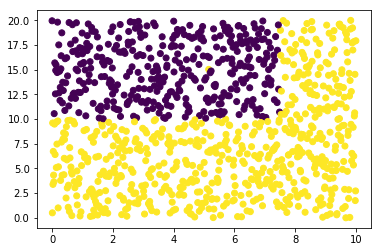

In [238]:
plt.scatter(treatment.X_1,treatment.X_2,c=treatment.Y)
plt.show()

In [245]:
x_1 = np.linspace(0, 7.5, endpoint=True, num=375)
x_2 = np.linspace(10,20,num=375)

np.random.shuffle(x_1)
np.random.shuffle(x_2)
y = np.zeros(375)



leaf_1 = pd.DataFrame({'X_1':x_1,'X_2':x_2,'Y':y})

x_1 = np.linspace(0, 10., endpoint=True, num=500)
x_2 = np.linspace(0,9.5,num=500)

np.random.shuffle(x_1)
np.random.shuffle(x_2)
y = np.ones(500)

leaf_2 = pd.DataFrame({'X_1':x_1,'X_2':x_2,'Y':y})

x_1 = np.linspace(7.55, 10., endpoint=True, num=125)
x_2 = np.linspace(10,20,num=125)

np.random.shuffle(x_1)
np.random.shuffle(x_2)
y = np.ones(125)

leaf_3 = pd.DataFrame({'X_1':x_1,'X_2':x_2,'Y':y})

data = pd.concat([leaf_1,leaf_2,leaf_3])

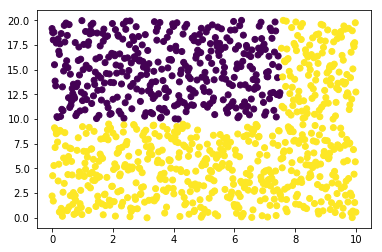

In [246]:
plt.scatter(data.X_1,data.X_2,c=data.Y)
plt.show()

In [281]:
x_1 = np.linspace(0, 7.5, endpoint=True, num=370)
x_2 = np.linspace(10,20,num=370)

np.random.shuffle(x_1)
np.random.shuffle(x_2)
y = np.zeros(370)

leaf_1 = pd.DataFrame({'X_1':x_1,'X_2':x_2,'Y':y})
impurity_1 = pd.DataFrame({'X_1':np.array([.6,5.3,2.,6.,3.]),'X_2':np.array([17.5,18.5,19.9,12.5,11.]),'Y':np.array([1,1,1,1,1])})

x_1 = np.linspace(0, 10., endpoint=True, num=497)
x_2 = np.linspace(0,9.5,num=497)

np.random.shuffle(x_1)
np.random.shuffle(x_2)
y = np.ones(497)

leaf_2 = pd.DataFrame({'X_1':x_1,'X_2':x_2,'Y':y})
impurity_2 = pd.DataFrame({'X_1':np.array([2,.2,6.]),'X_2':np.array([2.5,5.4,1.5]),'Y':np.array([0,0,0])})

x_1 = np.linspace(7.55, 10., endpoint=True, num=123)
x_2 = np.linspace(10,20,num=123)

np.random.shuffle(x_1)
np.random.shuffle(x_2)
y = np.ones(123)

leaf_3 = pd.DataFrame({'X_1':x_1,'X_2':x_2,'Y':y})
impurity_3 = pd.DataFrame({'X_1':np.array([9.,9.9]),'X_2':np.array([5.6,15.0]),'Y':np.array([0,0])})

data = pd.concat([leaf_1,leaf_2,leaf_3,impurity_1,impurity_2])#impurity_3])

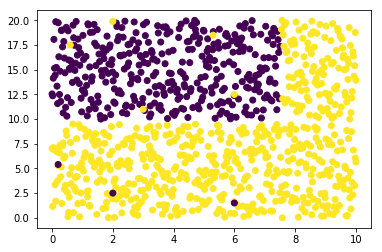

In [282]:
plt.scatter(data.X_1,data.X_2,c=data.Y)
plt.show()

In [291]:
x_1 = np.linspace(0, 7.5, endpoint=True, num=355)
x_2 = np.linspace(10,20,num=355)

np.random.shuffle(x_1)
np.random.shuffle(x_2)
y = np.zeros(355)

leaf_1 = pd.DataFrame({'X_1':x_1,'X_2':x_2,'Y':y})
impurity_1 = pd.DataFrame({'X_1':np.array([.4]*20),'X_2':np.array([15.]*20),'Y':np.array([1]*20)})

x_1 = np.linspace(0, 10., endpoint=True, num=500)
x_2 = np.linspace(0,9.5,num=500)

np.random.shuffle(x_1)
np.random.shuffle(x_2)
y = np.ones(500)

leaf_2 = pd.DataFrame({'X_1':x_1,'X_2':x_2,'Y':y})
impurity_2 = pd.DataFrame({'X_1':np.array([4]*20),'X_2':np.array([2.5]*20),'Y':np.array([0]*20)})

x_1 = np.linspace(7.55, 10., endpoint=True, num=125)
x_2 = np.linspace(10,20,num=125)

np.random.shuffle(x_1)
np.random.shuffle(x_2)
y = np.ones(125)

leaf_3 = pd.DataFrame({'X_1':x_1,'X_2':x_2,'Y':y})
impurity_3 = pd.DataFrame({'X_1':np.array([9.]*15),'X_2':np.array([15]*15),'Y':np.array([0]*15)})

control = pd.concat([leaf_1,leaf_2,leaf_3,impurity_1,impurity_2,impurity_3])

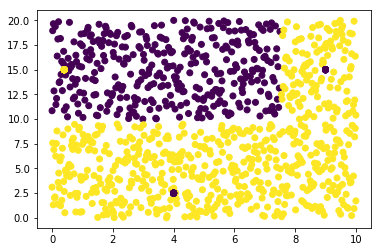

In [292]:
plt.scatter(control.X_1,control.X_2,c=control.Y)
plt.show()

In [293]:
?os.remove

Signature: os.remove(path, *, dir_fd=None)
Docstring:
Remove a file (same as unlink()).

If dir_fd is not None, it should be a file descriptor open to a directory,
  and path should be relative; path will then be relative to that directory.
dir_fd may not be implemented on your platform.
  If it is unavailable, using it will raise a NotImplementedError.
Type:      builtin_function_or_method
